In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
%load_ext autoreload

import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt


from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

In [3]:
from utils import MLP, RPNEnsemble, RingEncoding, ActuatorModel, Operator, BatchedDataset

## Loading Data

In [4]:
import pickle

In [5]:
data = pickle.load(open('data_subset.pkl', 'rb'))

# converts entries from string to float
data['contact_radius'] = data['contact_radius'].apply(float)
data['nominal_height'] = data['nominal_height'].apply(float)
data['nominal_thickness'] = data['nominal_thickness'].apply(float)
data['pressure'] = data['pressure'].apply(jnp.array)
data['force'] = data['force'].apply(lambda x : -jnp.array(x))
data['rings'] = data['rings'].apply(jnp.array)

In [6]:
data

,time,force,pressure,left_height,right_height,flow,contact,material,nominal_thickness,radius,contact_radius,year,month,day,A_B,nominal_height,trial,thicknesses,rings
0,"[6282, 6322, 6362, 6402, 6442, 6482, 6522, 656...","[0.0567, 0.0594, 0.0726, 0.0803, 0.0887, 0.097...","[0.0086, 0.0093, 0.0109, 0.0115, 0.0115, 0.013...","[110, 109, 113, 112, 112, 113, 110, 113, 111, ...","[123, 123, 121, 119, 123, 123, 121, 120, 124, ...","[22.4167, 22.4167, 22.2833, 22.2833, 22.2833, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",D10,1.0,70,25.4,24,01,11,A,0.0,0,"[1.11, 0.91, 0.9]","[nan, nan, nan, nan]"
0,"[2081, 2121, 2161, 2201, 2241, 2281, 2321, 236...","[0.0556, 0.0638, 0.0735, 0.0906, 0.1025, 0.112...","[0.0081, 0.0092, 0.01, 0.0106, 0.0117, 0.0122,...","[104, 104, 103, 105, 105, 106, 105, 105, 105, ...","[122, 125, 123, 122, 123, 121, 124, 123, 126, ...","[24.6167, 24.6167, 24.6167, 24.6167, 24.6167, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",D10,1.0,70,25.4,24,01,11,A,0.0,1,"[1.11, 0.91, 0.9]","[nan, nan, nan, nan]"
0,"[1922, 1962, 2002, 2042, 2082, 2122, 2162, 220...","[0.0551, 0.0692, 0.0799, 0.0934, 0.1036, 0.118...","[0.0072, 0.008, 0.0095, 0.0099, 0.0109, 0.0112...","[107, 105, 105, 105, 106, 105, 106, 106, 104, ...","[123, 124, 125, 125, 124, 123, 122, 122, 123, ...","[25.25, 25.25, 25.25, 25.25, 25.25, 25.25, 25....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",D10,1.0,70,25.4,24,01,11,A,0.0,2,"[1.11, 0.91, 0.9]","[nan, nan, nan, nan]"
0,"[4242, 4282, 4322, 4362, 4402, 4442, 4482, 452...","[0.0538, 0.0548, 0.0697, 0.0724, 0.0908, 0.093...","[0.0252, 0.0264, 0.0285, 0.0294, 0.0303, 0.031...","[112, 112, 117, 111, 110, 110, 111, 111, 114, ...","[132, 132, 133, 133, 133, 134, 133, 132, 134, ...","[25.25, 25.25, 25.25, 25.25, 25.25, 25.25, 25....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",D10,1.0,70,25.4,24,01,11,A,10.0,0,"[1.11, 0.91, 0.9]","[nan, nan, nan, nan]"
0,"[2681, 2721, 2761, 2801, 2841, 2881, 2921, 296...","[0.0522, 0.0615, 0.0649, 0.0744, 0.0837, 0.094...","[0.0235, 0.025, 0.0252, 0.0284, 0.0289, 0.0304...","[127, 125, 125, 121, 126, 126, 126, 122, 125, ...","[130, 131, 131, 132, 133, 134, 133, 135, 134, ...","[26.25, 26.25, 26.25, 26.25, 26.25, 26.25, 25....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",D10,1.0,70,25.4,24,01,11,A,10.0,1,"[1.11, 0.91, 0.9]","[nan, nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"[22565, 22605, 22645, 22685, 22725, 22765, 228...","[0.051, 0.0544, 0.0576, 0.0629, 0.0716, 0.0793...","[0.2748, 0.2751, 0.2765, 0.2772, 0.2777, 0.278...","[183, 179, 182, 183, 181, 184, 183, 182, 185, ...","[183, 186, 184, 186, 186, 183, 185, 185, 185, ...","[25.5667, 25.5667, 25.5667, 25.5667, 25.5667, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",E0030,2.0,70,38.1,24,09,02,A,60.0,1,"[nan, nan, nan]","[nan, nan, nan, nan]"
0,"[22405, 22445, 22485, 22525, 22565, 22605, 226...","[0.0598, 0.0606, 0.0689, 0.0792, 0.0811, 0.088...","[0.276, 0.2761, 0.2763, 0.2767, 0.2773, 0.2782...","[183, 182, 182, 181, 182, 182, 182, 182, 181, ...","[187, 184, 182, 184, 186, 184, 183, 186, 187, ...","[25.4167, 25.4167, 25.4167, 25.4167, 25.4167, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",E0030,2.0,70,38.1,24,09,02,A,60.0,2,"[nan, nan, nan]","[nan, nan, nan, nan]"
0,"[30847, 30887, 30927, 30967, 31007, 31047, 310...","[0.0516, 0.0541, 0.0615, 0.062, 0.0627, 0.0745...","[0.313, 0.313, 0.3133, 0.3133, 0.3137, 0.3138,...","[190, 189, 192, 190, 189, 190, 191, 191, 190, ...","[196, 194, 194, 194, 193, 197, 195, 196, 197, ...","[22.0167, 22.0167, 22.0167, 22.0167, 22.0167, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",E0030,2.0,70,38.1,24,09,02,A,70.0,0,"[nan, nan, nan]","[nan, nan, nan, nan]"
0,"[27367, 27407, 27447, 27487, 27527, 27567, 276...","[0.0576, 0.0608, 0.0556, 0.0658, 0.067, 0.0719...","[0.3089, 0.3094, 0.3094, 0.3093, 0.3093, 0.309...","[192, 191, 191, 192, 193, 191, 192, 191, 191, ...","[1

In [7]:
# Group by material and radius
grouped = data.groupby(['material'])
data_groups = []
names = []
for name, group in grouped:
    # Use multivariate data: thickness, force, pressure, and height
    # make a dataframe that is a subset of the group
    us, ys, forces = [], [], []
    us = jnp.hstack((jnp.array(group.nominal_height.values)[:,None],
                    jnp.array(group.nominal_thickness.values)[:,None],
                    jnp.array(group.contact_radius.values)[:,None],
                    jnp.stack(list(group.rings))))
    
    ys = list(group.pressure.values)
    forces = list(group.force.values)
    names.append(name)
    data_groups.append((us, ys, forces))

/tmp/ipykernel_73296/631243214.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


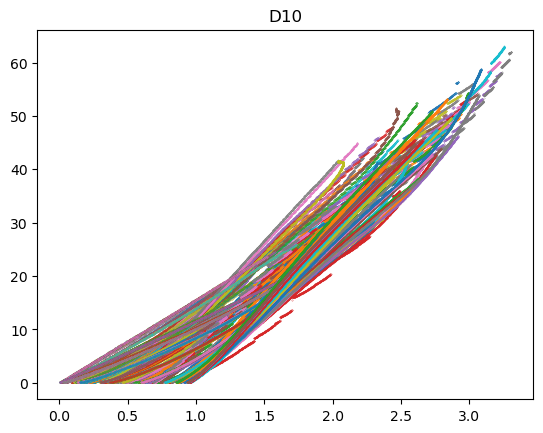

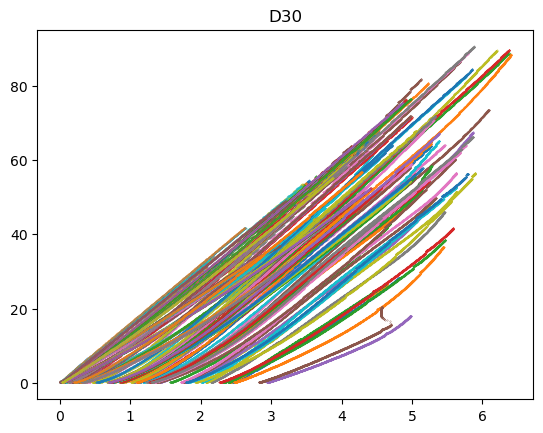

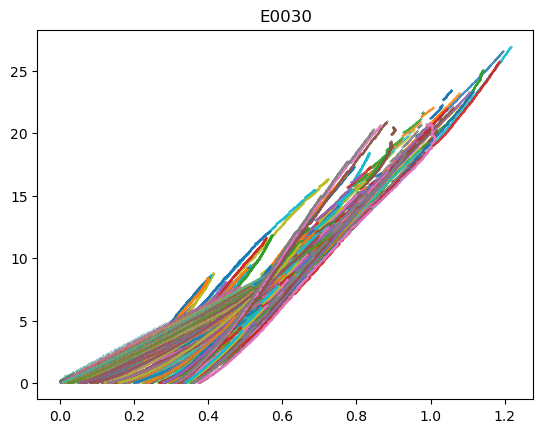

In [8]:
# plotting datasets
for i in range(len(data_groups)):
    plt.title(names[i])
    for j in range(data_groups[i][0].shape[0]):
        plt.scatter(data_groups[i][1][j], data_groups[i][2][j], s=.05)
    plt.show()

In [9]:
# Preparing data for training
training_data = []
for i in range(len(data_groups)):
    us, ys, fs = data_groups[i]
    organized_us = []
    organized_ys = []
    organized_fs = []
    for j in range(len(us)):
        # number of pressure measurements should be equal to force measurements
        assert len(ys[j]) == len(fs[j])
        num_measurements = len(ys[j])
        organized_us.append(jnp.tile(us[j], (num_measurements,1)))
    training_data.append(((jnp.concatenate(organized_us),jnp.concatenate(ys)[:,None]),
                          jnp.concatenate(fs)[:,None]))
    print(f'training shapes for group {i}:')
    print(f'us : {training_data[-1][0][0].shape}')
    print(f'ys : {training_data[-1][0][1].shape}')
    print(f'fs : {training_data[-1][1].shape}')

training shapes for group 0:
us : (222116, 7)
ys : (222116, 1)
fs : (222116, 1)
training shapes for group 1:
us : (237924, 7)
ys : (237924, 1)
fs : (237924, 1)
training shapes for group 2:
us : (206305, 7)
ys : (206305, 1)
fs : (206305, 1)


## Training Model

In [28]:
# Define Model
ring_encoder = RingEncoding(4,
                            MLP([12,5]))
arch = ActuatorModel(ring_encoder,
                     MLP([32, 16], output_activation=nn.gelu),
                     polynomial_degree=2)
ensemble = RPNEnsemble(arch, 128)

model = Operator(ensemble, training_data[0])
print(model.tabulate())


                                             RPNEnsemble Summary                                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                 ┃ module           ┃ inputs              ┃ outputs             ┃ params               ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│                      │ RPNEnsemble      │ - float32[222116,7] │ float32[128,222116… │                      │
│                      │                  │ - float32[222116,1] │                     │                      │
├──────────────────────┼──────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble │ - float32[222116,7] │ float32[256,222116… │                      │
│                      │                  │ - float32[222116,1] │                     │                      │


In [29]:
print('Correspondence of material numbers:')
for i in range(len(names)):
    print(f'{i} - {names[i]}')

Correspondence of material numbers:
0 - D10
1 - D30
2 - E0030


Training on material D10


100%|██████████| 8000/8000 [02:00<00:00, 66.17it/s, loss=2.00595, grad_norm=0.1260674]    


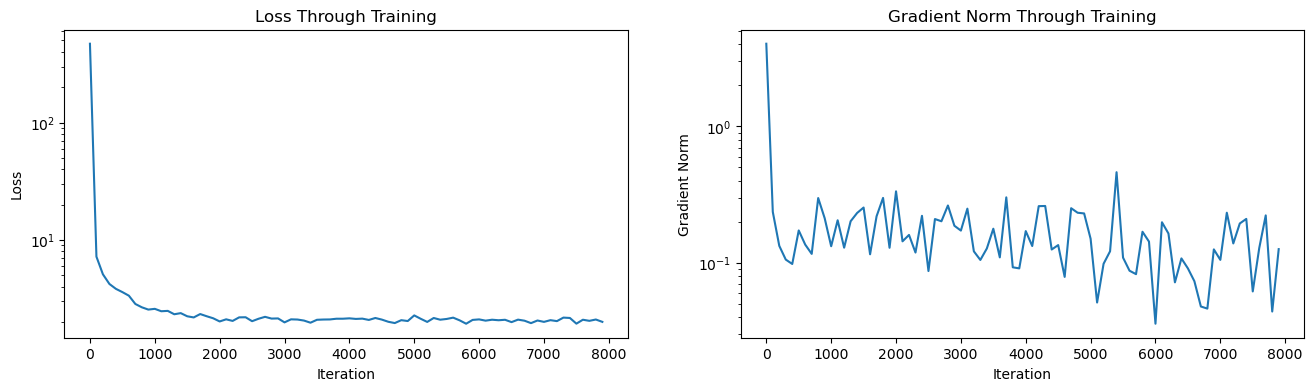

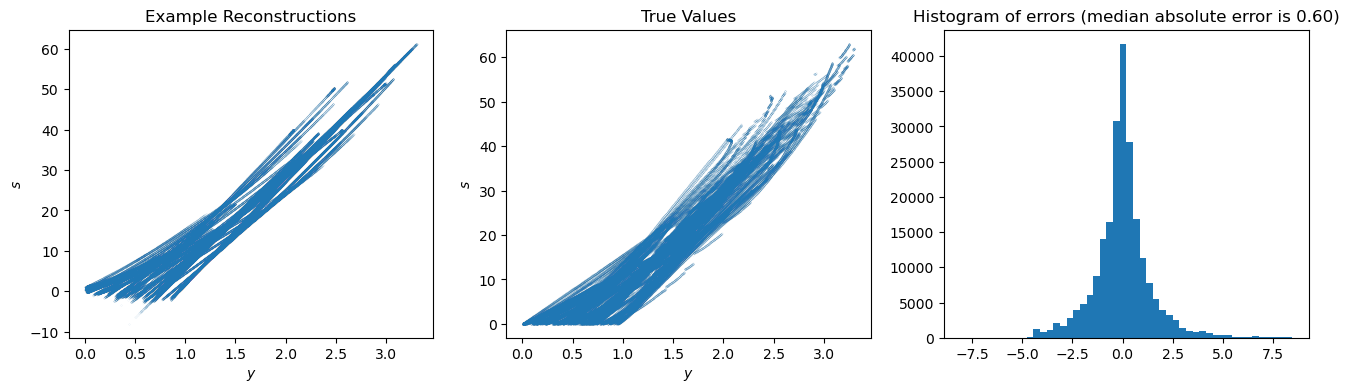

In [30]:
material_num = 0 # use correspondence above to select which material to test
model = Operator(ensemble, training_data[material_num]) #restart model
data_loader = BatchedDataset(training_data[material_num], key=random.PRNGKey(58), batch_size=5_000)
print('Training on material ' + names[material_num])
model.train(data_loader, nIter=8_000)
model.plot_training_log()
model.plot_predictions(training_data[material_num])

## Acquisition

In [31]:
%autoreload 2
from acquisition import MCAcquisition

In [32]:
# Parameters for material
_radius = 70. # radius of the entire membrane
_min_spacing = 3. # minimum spacing between rings and other rings/boundaries
_min_width = 5. # minimum width of each ring

_tmin = 1. # minimum membrane thickness
_tmax = 3. # maximum membrane thickness
_contactmin = 25.4 # minimum contact disk radius
_contactmax = 38.1  # maximum contact disk radius

### Setup (you probably don't need to change anything here)

In [33]:
# computes radii and widths of rings
# effectively, this function transforms numbers between 0 and 1 into the proper ring parameters
def get_rw(w0, ring_params, num_rings, radius=_radius, min_spacing=_min_spacing, min_width=_min_width, max_rings=2):
    ring_params = ring_params.sort() # sorts entries from smallest to largest
    available_space = radius - w0 - min_spacing*(num_rings+1) - 2*min_width*num_rings
    #assert (available_space>0), "There is no space available for rings!"
    radii = [w0 + (i+1)*min_spacing + (2*i+1)*min_width +  available_space*(ring_params[2*i+1]+ring_params[2*i])/2 for i in range(num_rings)]
    widths = [min_width + available_space*(ring_params[2*i+1]-ring_params[2*i])/2 for i in range(num_rings)]
    radii = jnp.array(radii + (max_rings-num_rings)*[jnp.nan])
    widths = jnp.array(widths + (max_rings-num_rings)*[jnp.nan])
    return jnp.ravel(jnp.vstack([radii, widths]), order='F')

In [34]:
# 'optimization variables to physical variables'
def opt_var_to_phys_var(membrane_coefs, num_rings, max_rings=2):
    material_params = membrane_coefs[:2]
    ring_params = jnp.concatenate([membrane_coefs[2:], jnp.array(2*(max_rings-num_rings)*[jnp.nan])])
    ring_params = get_rw(material_params[1], ring_params, num_rings)

    membrane = jnp.concatenate([material_params, ring_params])
    return membrane

def print_recommendations(u_new):
    q = u_new.shape[0]
    num_rings = 2 - jnp.isnan(u_new).sum() // (2*q)
    for j in range(q):
        print(f'\nMembrane {j+1}:')
        print(f'thickness: {u_new[j][0] : .2f}')
        print(f'contact radius: {u_new[j][1] : .2f}')
        for i in range(num_rings):
            print(f'Ring {i+1}) radius: {u_new[j][i*2 + 2] : .2f}; width: {u_new[j][i*2 + 3] : .2f}')

def get_posterior_fn(model, num_rings, hs, pmin, pmax, num_ps, max_rings=2, tmin=_tmin, tmax=_tmax, contactmin=_contactmin, contactmax=_contactmax):
    
    # computing bounds
    #lb = jnp.array([tmin, contactmin] + 2*num_rings*[0] + 2*(max_rings-num_rings)[jnp.nan])
    #ub = jnp.array([tmax, contactmax]+ 2*num_rings*[1] + 2*(max_rings-num_rings)[jnp.nan])
    lb = jnp.array([tmin, contactmin] + 2*num_rings*[0.])
    ub = jnp.array([tmax, contactmax]+ 2*num_rings*[1.])

    # function to compute posterior function
    def posterior(membrane_coefs):
        # membrane_coefs is a vector with up to 6 entries: t, w0, r1, w1, r2, w2
        '''
        material_params = membrane_coefs[:2]
        ring_params = jnp.concatenate([membrane_coefs[2:], jnp.array(2*(max_rings-num_rings)*[jnp.nan])])
        ring_params = get_rw(material_params[1], ring_params, num_rings)

        membrane = jnp.concatenate([material_params, ring_params])
        '''

        membrane = opt_var_to_phys_var(membrane_coefs, num_rings, max_rings)

        #preparing us
        us = [jnp.concatenate([jnp.array([h]), membrane])[None,:] for h in hs] # list of num_hs vectors of shape (1, 7) each
        us = [jnp.tile(u, (num_ps, 1)) for u in us] # list of num_hs vectors of shape (num_ps, 7) each
        us = jnp.concatenate(us) # shape (num_ps*num_hs, 7)

        # preparing pressures
        ys = jnp.linspace(pmin, pmax, num_ps)[:,None] # shape (num_ps, 1)
        ys = jnp.tile(ys, (len(hs),1)) # shape (num_ps*num_hs, 1)

        # making predictions
        samples = model.apply(model.params, us, ys) # shape (num_ensembles, num_ps*num_hs, 1)
        return samples
    # returns posterior function and bounds for optimization
    return posterior, (lb, ub)

In [35]:
# you probably don't need to change these values
#hs = set(data.nominal_height.values)
hs = jnp.linspace(0, 30., 4)
pmin = 0.
pmax = 3.
num_ps = 20

### Selecting next experiments

In [36]:
q = 2 # number of membranes to be collected next
seed = 3 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in range(3):
    posterior, bounds = get_posterior_fn(model, num_rings, hs, pmin, pmax, num_ps)
    acquisition = MCAcquisition(vmap(posterior), bounds)
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=1_000, seed=seed)
    u_new = vmap(opt_var_to_phys_var, in_axes=(0,None))(u_new.reshape((q,-1)), num_rings)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new))

Determining best membranes to test using 0 rings...


100%|██████████| 1000/1000 [00:18<00:00, 53.25it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s]


Determining best membranes to test using 2 rings...


100%|██████████| 1000/1000 [00:48<00:00, 20.47it/s]


In [37]:
best_num_rings = jnp.argmin(jnp.array(objs))
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
print_recommendations(recs[best_num_rings])

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane 1:
thickness:  3.00
contact radius:  38.10
Ring 1) radius:  46.10; width:  5.00
Ring 2) radius:  60.59; width:  6.41

Membrane 2:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  35.40; width:  7.00
Ring 2) radius:  56.20; width:  10.80


In [38]:
print("Here are the recommendations considering all possibilities.")
print("Higher acquisition scores indicate higher epistemic uncertainty.")
for num_rings in range(3):
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2f}):')
    print_recommendations(recs[num_rings])

Here are the recommendations considering all possibilities.
Higher acquisition scores indicate higher epistemic uncertainty.

------------------

Using 0 rings (acquisition score is  5.68):

Membrane 1:
thickness:  3.00
contact radius:  38.10

Membrane 2:
thickness:  3.00
contact radius:  25.40

------------------

Using 1 rings (acquisition score is  15.66):

Membrane 1:
thickness:  3.00
contact radius:  38.10
Ring 1) radius:  55.79; width:  5.01

Membrane 2:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  47.70; width:  19.30

------------------

Using 2 rings (acquisition score is  24.40):

Membrane 1:
thickness:  3.00
contact radius:  38.10
Ring 1) radius:  46.10; width:  5.00
Ring 2) radius:  60.59; width:  6.41

Membrane 2:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  35.40; width:  7.00
Ring 2) radius:  56.20; width:  10.80
